# 5 - OCC geometries

In this tutorial we discuss how to define a geometry programmatically using the Open Cascade Technology (OCC) geometry supported by Netgen and NGSolve. Unlike the $\texttt{.geo}$ files the OCC geometries are defined in Python files ($\texttt{.py}$) and supports all Python functionality. For example importing libraries, defining variables, and control statements.

The OCC module of Netgen is imported as

In [1]:
from netgen.occ import *

and documentation for individual functions and classes can be accessed via the $\texttt{help}$ function. For example to obtain the documentation for a sphere we would use

In [2]:
help(Sphere)

Help on built-in function Sphere in module netgen.libngpy._NgOCC:

Sphere(...) method of builtins.PyCapsule instance
    Sphere(c: netgen.libngpy._NgOCC.gp_Pnt, r: float) -> netgen.libngpy._NgOCC.Solid
    
    create sphere with center 'c' and radius 'r'



Currently, NGSolve reccomends that OCC geometries be used rather than $\texttt{.geo}$ files, but there is little documentation avaliable about avaliable primatives and methods. For documentation, we refer the user to the NGSolve documentation and the Open Cascade Technology bottle example:

[https://docu.ngsolve.org/latest/i-tutorials/unit-4.4-occ/occ.html](https://docu.ngsolve.org/latest/i-tutorials/unit-4.4-occ/occ.html). 

[https://dev.opencascade.org/doc/overview/html/occt__tutorial.html](https://dev.opencascade.org/doc/overview/html/occt__tutorial.html)
 

## Structure of the OCC python files
In a similar way to the $\texttt{.geo}$ files, we mandate that each of the $\texttt{.py}$ OCC files follow a specific format that MPT-Calculator accepts.

The OCC Python files are stored in the $\texttt{OCC_Geometry/}$ folder.

All files must contain the following variables: $\texttt{object_name}$, $\texttt{sigma}$, and $\texttt{mur}$ corresponding to the names of the different sub-region that make up the object and their conductivity (S/m) and relative magnetic permeability values respectively in the form of the lists: 
```python
object_name = ['object 1', 'object 2', ... ]
sigma = [conductivity_1, conductivity_2, ...]
mur = [mur_1, mur_2, ...]
```
These are easiest to implement at the top of the file. In the simplest case, where the object is just made up of one region (or primitive) there is only a single entry in each of these lists. e.g.

```python
object_name = 'sphere'
sigma = 1e6
mur = 1
```

sets up an object which we will call $\text{'sphere'}$ with properties $\sigma_*=1e6$ and $\mu_r=1$.

Secondly, there must be a valid object description using the avaliable OCC primatives and a defined non-conducting region. For example:

```python
sphere = Sphere(Pnt(0,0,0), r=1)
box = Box(Pnt(-1000, -1000, -1000), Pnt(1000,1000,1000))
```
defines a sphere of radius 1 and a large cube, centered at (0,0,0) and of side length 2000.

We also need to specify material names, boundary condition names, and any additional properties (e.g. $\texttt{maxh}$). For compatability with MPT-Calculator, we want the non-conducting region to have the 'outer' boundary condition and be labeled as 'air'. In addition, the material name for the conducting object must match one of the entries in $\texttt{object_name}$:

```python
sphere.mat(object_name[0])
sphere.bc('default')
box.mat('air')
box.bc('outer')
```
Finally, we need to join the non-conducting region with the conducting object. To avoid interior elements, we use the $\texttt{Glue}$ method:
```python
joined_object = Glue([sphere, box])
```

The output mesh file ($\texttt{.vol}$) must be named using the same file name as the $\texttt{.py}$ file. For example, if we have a OCC geometry file $\texttt{OCC_sphere.py}$ then we must save the output as $\texttt{OCC_sphere.vol}$ in the $\texttt{VolFiles/}$ directory:
```python
geo = OCCGeometry(joined_object)
nmesh = geo.GenerateMesh()
nmesh.Save(r'VolFiles/OCC_sphere.vol')
```

<b>Example OCC files can be found in the $\texttt{OCC_Geometry/}$ directory.</b>


## Computing £1 coin as a regular dodecagon of radius r mm:
In this example, we cover the steps required to generate a mesh of a £1 coin using the OCC geometry. We model the coin as a regular dodecagonal prism consisting of an inner cylinder, an outer annulus, and a thin metallic coating.


 <img src="Figures/large_new_pound.webp" alt="isolated" width="200"/>

We begin by importing the standard libraries

In [3]:
from netgen.occ import *
import numpy as np
from netgen.webgui import Draw as DrawGeo

As with other objects, we define lists of object names and corresponding lists for the $\sigma_*$ and $\mu_r$ values in each region that makes up the object. In the case of the £1 coin, we have 3 regions to consider (which each have different materials)
- The outer Nickel-Silver ring
- The inner cylinder, which is a brass disk
- A thin layer of Nickel platiing applied to the central disk.

For each region, we define a name, a conductivity $\sigma_*$ (S/m), and a relative permeability $\mu_r$.

In [4]:
object_name = ['outer_frame', 'inner_cyln', 'plating']
sigma = [5.26E+06, 1.63E+07, 1E6]
mur = [1.15, 1, 100]

In [5]:
r = 23.43/2
t = 2.8

To define a dodegagon, we also need the side length. Since we know that there are 12 sides we know all the angles involved and can use the sine rule to obtain the chord length a.

In [6]:
a = r * np.sin(30 * np.pi/180) / np.sin(75 * np.pi/180)

Now that we have the radius and segment length, we can iterativly constuct a dodecagon of radius r and side length a.

### Building the dodecagon

WorkPlanes allows us to construct 2D shapes, in a similar way to turtle graphics, by moving and updating a cursor. 

In [7]:
wp = WorkPlane()
for i in range(12):
    wp.Line(a).Rotate(30)
face = wp.Face()
DrawGeo(face)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

Now, we can turn this 2D shape into a 3D volume by extruding the face to the thickness of the coin: 

In [8]:
frame = face.Extrude(t)
DrawGeo(frame)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

### Adding the interior
We now add the interior cylinder. To do this, we define a cylinder of radius r_inner and the same thickness as the rest of the coin:

In [9]:
r_inner = 7.4

In [10]:
cx = frame.center[0]
cy = frame.center[1]
inner_cyln = Cylinder(Pnt(cx,cy,0),Z, r=r_inner, h=t)

We can now subtract the inner cylinder from the rest of the coin to obtain only the outer region:

In [11]:
frame_outer = frame - inner_cyln
DrawGeo(frame_outer)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

We now have everything we need to build the final coin, but before we join everything together we add object and material names, boundary condition names, and define the desired mesh density:

In [12]:
inner_cyln.mat(object_name[1])
frame_outer.mat(object_name[0])
inner_cyln.bc('inner')
inner_cyln.name = 'inner_cyln'
frame_outer.bc('frame_outer')
frame_outer.name = 'frame_outer'
inner_cyln.maxh = 1
frame_outer.maxh = 1

Finally, we can now build our final object:

In [13]:
coin = Glue([inner_cyln, frame_outer])
DrawGeo(coin)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

and add a large outer non-conducting region:

In [14]:
box = Box(Pnt(-1000, -1000, -1000), Pnt(1000,1000,1000))
box.mat('air')
box.bc('outer')
box.maxh = 1000

### Generating Mesh
We have now defined the entire geometry of what we want to simulate and assigned the appropriate metadata. All that is left to do it to generate a mesh:

In [15]:
joined_object = Glue([coin, box])
geo = OCCGeometry(joined_object)
nmesh = geo.GenerateMesh()

The real £1 coin has a thin Nickel plating around the central cylinder. We can model this using a thin layer of prismatic elements by adding boundary layer elements of 50 $\mu$m thickness and tagged as Nickel to the inner part of the coin.

In [16]:
nmesh.BoundaryLayer(boundary=".*", thickness=[5e-5], material=object_name[2],
                           domains='inner_cyln', outside=False)

Finally, we save the mesh to disk.

In [17]:
nmesh.Save(r'VolFiles/OCC_coin.vol')

We can also visualise the mesh using the NGSolve Draw function

In [18]:
from ngsolve import *
from ngsolve.webgui import Draw
ngmesh = Mesh(nmesh)
Draw(ngmesh, clipping=True)

importing NGSolve-6.2.2203


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, …

BaseWebGuiScene

## Using OCC geometries with MPT-Calculator
To use a defined OCC geometry with MPT-Calculator, we set the $\texttt{use_OCC}$ argument in the main function.

```python
main(use_OCC=True)
```

OCC_coin.geo
 mesh contains 34196 elements
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
 solved theta0 problems    
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
importing NGSolve-6.2.2203
Frequency Sweep complete 


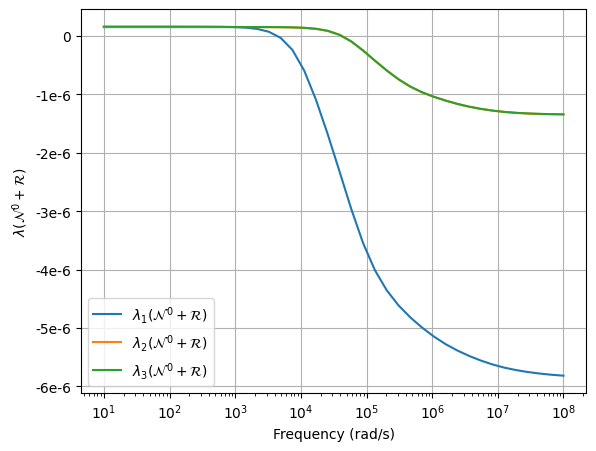

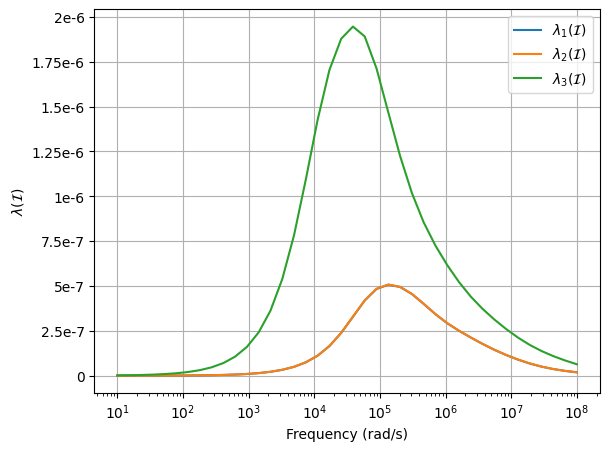

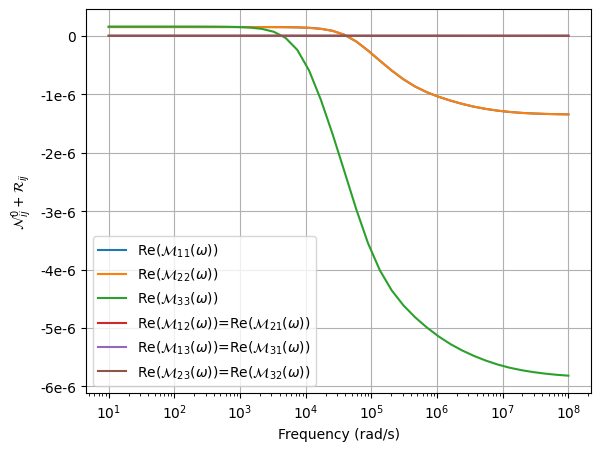

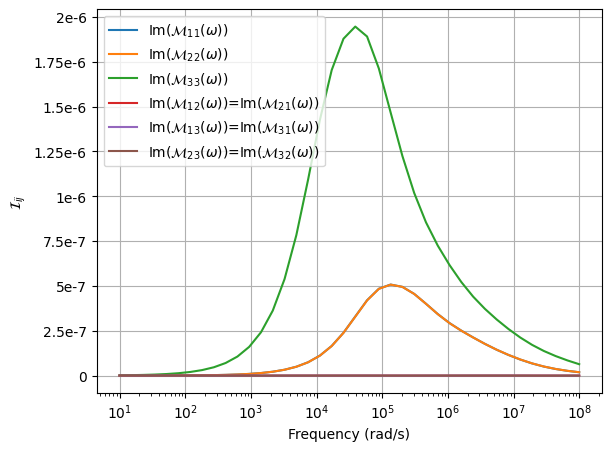

In [19]:
import os
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

from main import main
main(geometry='OCC_coin.py', use_OCC=True);

## Saving Results
When using the OCC geometries, MPT-Calculator saves a copy of the $\texttt{.py}$ file used to define the geometry, along with the mesh, Settings files, graphs, and raw output files.